In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
download_speed_dir = "./download_speed/"
fairness_dir = "./fairness/"
figures_dir = "./figures/"
bandwidth_sizes = ["1mbps", "10mbps", "100mbps", "1000mbps"]
file_sizes = ["5KB.txt", "10KB.txt", "100KB.txt", "200KB.txt", "500KB.txt", "1MB.txt", "10MB.txt"]
clients = ["HTTP", "QUICHE"]
num_connections = [str(x + 1) for x in range(3)]

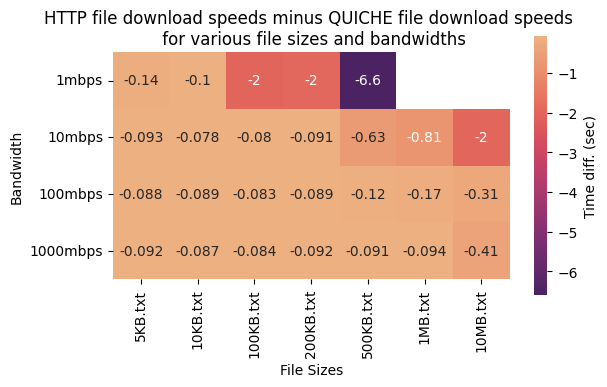

In [ ]:
def generate_download_speed_heatmap():
    combined_df = pd.DataFrame(columns=file_sizes)
    for bandwidth_size in bandwidth_sizes:
        http_df = pd.read_csv(f"{download_speed_dir}{bandwidth_size}_HTTP.csv")
        quiche_df = pd.read_csv(f"{download_speed_dir}{bandwidth_size}_QUICHE.csv")
        combined_df.loc[bandwidth_size] = (
            http_df.mean(axis=0).subtract(quiche_df.mean(axis=0)).rename(bandwidth_size)
        )

    p = sns.heatmap(
        combined_df,
        annot=True,
        cmap="flare_r",
        square=True,
        cbar_kws={"shrink": 0.7, "label": "Time diff. (sec)"},
    )
    p.set_title("HTTP file download speeds minus QUICHE file download speeds \n for various file sizes and bandwidths")
    p.set_xlabel("File Sizes (KB)")
    p.set_ylabel("Bandwidth (Mbps)")

generate_download_speed_heatmap()

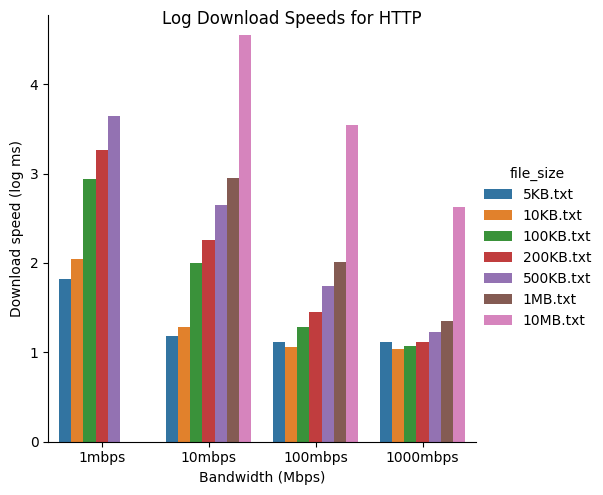

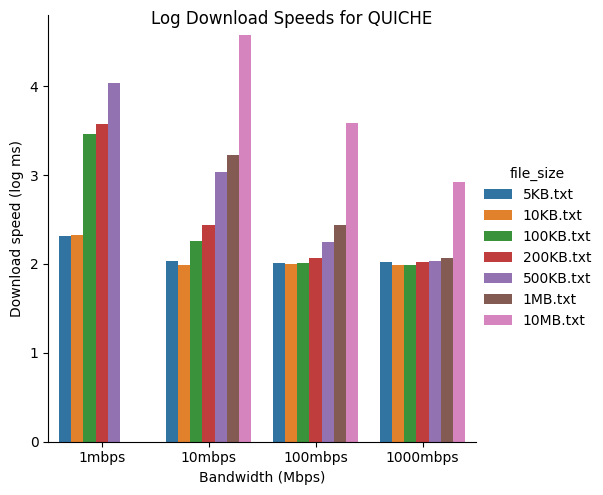

In [94]:
def generate_within_client_download_speed_comparison_graph(client):
    frames = []
    for bandwidth_size in bandwidth_sizes:
        df = pd.read_csv(f"{download_speed_dir}{bandwidth_size}_{client}.csv")
        melted = pd.melt(df.mean(axis=0).to_frame().T, var_name="file_size", value_name="download_speed")
        melted["bandwidth"] = bandwidth_size
        frames.append(melted)    

    combined = pd.concat(frames, ignore_index=True)
    combined["download_speed"] = np.log10(combined["download_speed"] * 1000)
    p = sns.catplot(
        x="bandwidth",
        y="download_speed",
        hue="file_size",
        data=combined,
        kind="bar",
    )
    p.set_xlabels(f"Bandwidth (Mbps)")
    p.set_ylabels(f"Download speed (log ms)")
    p.figure.suptitle(f"Log Download Speeds for {client}")

for client in clients:
  generate_within_client_download_speed_comparison_graph(client)

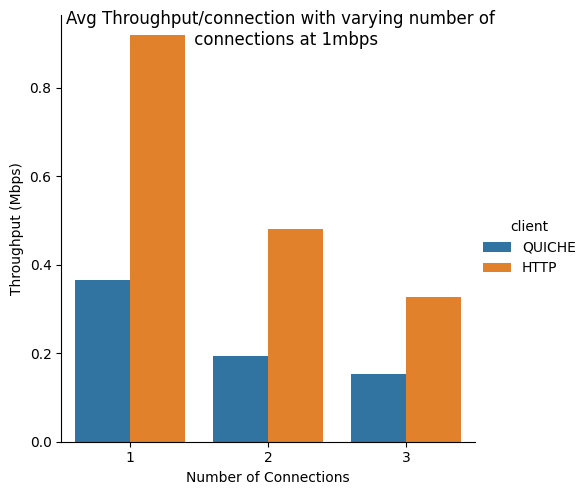

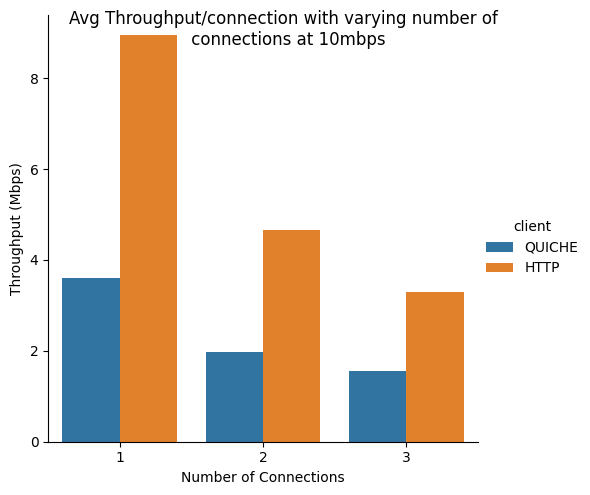

In [121]:
def generate_fairness_comparison_graph_by_bandwidth(bandwidth):
    frames = []
    for client in ["QUIC", "HTTP"]:
        for conn in num_connections:
            df = pd.read_csv(f"{fairness_dir}{client}_{bandwidth}_conns_{conn}.csv")
            frames.append(
                pd.DataFrame(
                    {
                        "throughput": [df.to_numpy().mean()],
                        "client": [client if client == "HTTP" else "QUICHE"],
                        "connections": [conn],
                    }
                )
            )

    combined = pd.concat(frames, ignore_index=True)
    p = sns.catplot(
        x="connections",
        y="throughput",
        hue="client",
        data=combined,
        kind="bar",
    )
    p.set_xlabels(f"Number of Connections")
    p.set_ylabels(f"Throughput (Mbps)")
    p.figure.suptitle(f"Avg Throughput/connection with varying number of \n connections at {bandwidth}")


for bandwidth in bandwidth_sizes[:2]:
    generate_fairness_comparison_graph_by_bandwidth(bandwidth)